In [2]:
import jax.numpy as jnp
from jax import grad, jit, vmap
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D      
from functools import partial
from rikabplotlib.plot_utils import newplot
import math


Integral of RDF: nan


/tmp/ipykernel_69194/2264421726.py:117: UserWarning: The following kwargs were not used by contour: 'color'
  ax.contourf(t_a, t_b, Z_fo, zdir='z', offset=0, color = "black", alpha=0.75)


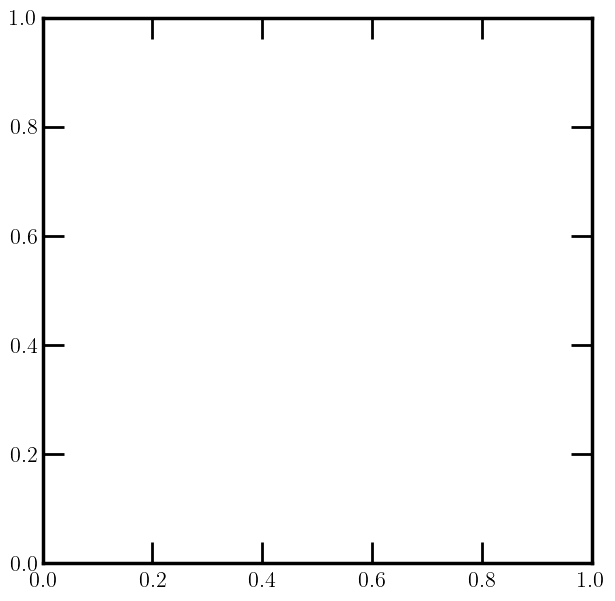

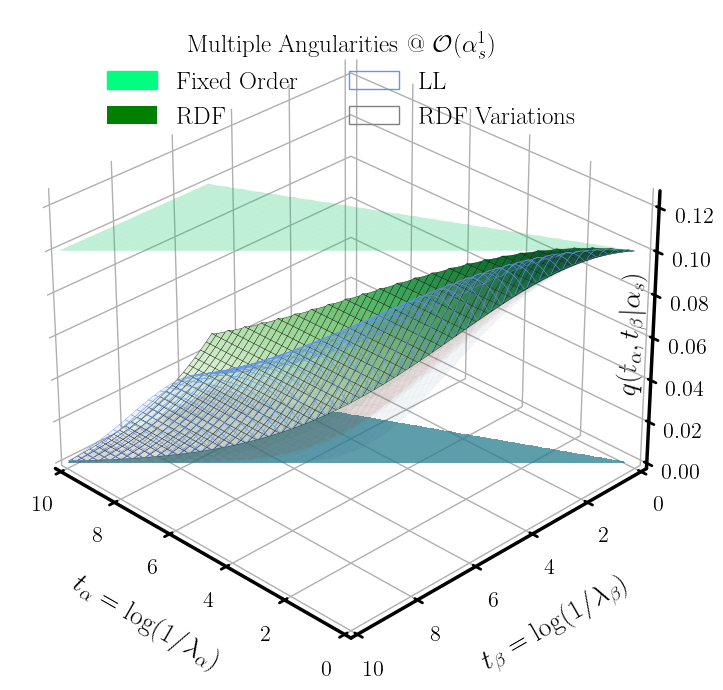

In [16]:



alpha = 0.118
C_F = 4/3
a = 2
b = 1


def Theta(x):

    return jnp.where(x > 0, 1.0, 0.0)


def Theta_ab(t_a, t_b):

    return Theta(t_a - t_b) * Theta((a/b) * t_b - t_a)



def pdf_t(t_a, t_b):

    pref = 2 * alpha * C_F / jnp.pi 
    return pref / (a - b) * Theta_ab(t_a, t_b)


def pdf_ta(t_a):

    pref = 2 * alpha * C_F / jnp.pi / b
    return pref * t_a


def pdf_tb(t_b):

    pref = 2 * alpha * C_F / jnp.pi  / b
    return pref * t_b

    


def rdf_t(t_a, t_b):

    pref = 2.0 * alpha * C_F / jnp.pi  
    R = (alpha * C_F / jnp.pi) * (t_b**2 / b)  
    return pref / (a - b) * jnp.exp(-R) * Theta_ab(t_a, t_b)


def rdf_LL(t_a, t_b):
    A = alpha * C_F / jnp.pi
    pref = 2.0 * A / (a - b)
    R = A * (t_b**2 / b + (t_a - t_b)**2 / (a - b))
    poly = 1.0 + (2.0 * A / (a - b)) * ((t_b - t_a) * (b * t_a - a * t_b) / b)
    return pref * poly * jnp.exp(-R) * Theta_ab(t_a, t_b)


def rdf_t_variation(t_a, t_b):

    # Generate 3x3 random coefficients for a 2d polynomial
    gs = np.random.normal(size=(3,3)) * 0.01
    gs[-1, -1] = -jnp.abs(gs[-1, -1])  # Ensure the last coefficient is negative
    gs[-1, :] = -jnp.abs(gs[-1, :])  # Ensure the last row is negative
    gs[:, -1] = -jnp.abs(gs[:, -1])  # Ensure the last column is negative

    # 2d polynomial
    poly = 0
    poly_t_int = 0
    for i in range(gs.shape[0]):
        for j in range(gs.shape[1]):
            poly += gs[i,j] * (t_a**i) * (t_b**j) / (math.factorial(i) * math.factorial(j))
            poly_t_int += gs[i,j] * (t_a**(i+1)) * (t_b**j) / (i + 1) / (math.factorial(j) * math.factorial(i))


    base_pref = 2.0 * alpha * C_F / jnp.pi
    base_R = (alpha * C_F / jnp.pi) * (t_b**2 / b) 
    lam = base_pref / (a - b)

    return lam * Theta_ab(t_a, t_b) * jnp.exp(-base_R + lam * poly_t_int) * jnp.exp(lam * poly)



# Draw 3d plot of the PDF
fig, ax = newplot("full")
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': '3d'})
ax.view_init(elev=30, azim=135, roll=0)


t_a = jnp.linspace(0.0, 10.0, 200)
t_b = jnp.linspace(0.0, 10.0, 200)
T_A, T_B = jnp.meshgrid(t_a, t_b, indexing="xy")

Z_fo = pdf_t(T_A, T_B)       # FO joint
Z_fo = jnp.where(Z_fo < 1e-10, jnp.nan, Z_fo)

Z_r = rdf_t(T_A, T_B)        # RDF joint
Z_r = jnp.where(Z_r < 1e-10, jnp.nan, Z_r)

Z_LL = rdf_LL(T_A, T_B)
Z_LL = jnp.where(Z_LL < 1e-10, jnp.nan, Z_LL)


# Integrate over t_a and t_b
Z_r_a = jnp.trapz(Z_r, t_b, axis=1)
Z_r_b = jnp.trapz(Z_r, t_a, axis=0)


# print integral of the RDF
integral_rdf = jnp.trapz(jnp.trapz(Z_r, t_b, axis=1), t_a, axis=0)
print(f"Integral of RDF: {integral_rdf}")

Z_r = jnp.where(Z_r < 1e-10, jnp.nan, Z_r)  # Avoid log(0) issues


# # # Plot 2d Projections
# scale = 0.1
# ax.plot(t_a , scale * pdf_ta(t_a), color='red', label=r'$p(t_a)$', zdir ='y', zs=0, alpha=0.5)
# ax.plot( t_b, scale * pdf_tb(t_b), color='red', label=r'$p(t_b)$', zdir ='x', zs=10, alpha=0.5)
# ax.plot(t_a, scale * Z_r_a, zs=0, color='cornflowerblue', label=r'$q(t_a)$', zdir='y', alpha=0.5)
# ax.plot(t_b, scale * Z_r_b, zs=10, color='cornflowerblue', label=r'$q(t_b)$', zdir='x', alpha=0.5)

ax.contourf(t_a, t_b, Z_fo, zdir='z', offset=0, color = "black", alpha=0.75)


# Plot 10 variations of the RDF
for i in range(5):
    Z_r_v = rdf_t_variation(T_A, T_B)
    Z_r_a_v = jnp.trapz(Z_r_v, t_b, axis=1)
    Z_r_b_v = jnp.trapz(Z_r_v, t_a, axis=0)
    Z_r_v = jnp.where(Z_r_v < 1e-10, jnp.nan, Z_r_v)  # Avoid log(0) issues
    ax.plot_surface(T_A, T_B, Z_r_v, color = None, edgecolor='grey', lw=0.01, alpha=0.05)

    # Integrate over t_a and t_b for the variation

    # Z_r_a_v = jnp.where(Z_r_a_v < 1e-10, jnp.nan, Z_r_a_v)  # Avoid log(0) issues
    # Z_r_b_v = jnp.where(Z_r_b_v < 1e-10, jnp.nan, Z_r_b_v)  # Avoid log(0) issues   

    # print(Z_r_a_v)

    # ax.plot(t_a, scale * Z_r_a_v, zs=0, color='cornflowerblue', zdir='y', alpha=0.05)
    # ax.plot(t_b, scale * Z_r_b_v, zs=10, color='cornflowerblue', zdir='x', alpha=0.5)



ax.plot_surface(T_A, T_B, Z_fo, color = "springgreen", edgecolor='none', rcount = 50, ccount = 50, alpha=0.25, lw = 1, label = "Fixed Order")



ax.plot_surface(T_A, T_B, Z_r, cmap = "Greens", edgecolor='black',  lw = 0.25, label = "RDF")

ax.plot_surface(T_A, T_B, Z_LL, color="cornflowerblue", edgecolor="cornflowerblue",  lw = 0.25, label = "LL", alpha = 0.1)



ax.set_xlabel(r'$t_\alpha = \log(1/\lambda_\alpha)$')
ax.set_ylabel(r'$t_\beta = \log(1/\lambda_\beta)$')

# ax.zaxis.set_rotate_label(False)
ax.set_zlabel(r'$q(t_\alpha, t_\beta | \alpha_s)$')

# set spacing of label away from the axes
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20
ax.zaxis.labelpad = -30


plt.xlim(0, 10)
plt.ylim(0, 10)

ax.set_zlim(0, 0.125)
# ax.legend()

fig.subplots_adjust(left=0.05, right=0.88, bottom=0.05, top=0.95)


ax.xaxis.pane.set_alpha(0.0)
ax.yaxis.pane.set_alpha(0.0)
ax.zaxis.pane.set_alpha(0.0)
ax.grid(True, alpha=0.2)



from matplotlib.patches import Patch

fo_patch  = Patch(facecolor="springgreen",      edgecolor="springgreen", label="Fixed Order")
rdf_patch = Patch(facecolor="green",       edgecolor="none", label="RDF")
ll_patch  = Patch(facecolor="none",  edgecolor="cornflowerblue", label="LL")
rand_patch  = Patch(facecolor="none",  edgecolor="grey", label="RDF Variations")

ax.legend(handles=[fo_patch, rdf_patch, ll_patch, rand_patch],
          loc="upper center",
          title = r"Multiple Angularities @ $\mathcal{O}(\alpha_s^1)$",
          ncol = 2)

plt.savefig("plots/multi_angularity.pdf", bbox_inches = "tight")